# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [133]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [134]:
#import all necessary modules
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import path
%matplotlib inline 

In [135]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [136]:
#Make an array of the temperature column of the df: df_temp
df_temp = df['temperature']

# Compute mean and standard deviation: df_mean, df_std
df_mean = np.mean(df_temp)
df_std = np.std(df_temp)

## 1. Is the distribution of body temperatures normal?

### Visual Test with CDFs

Since the theoretical CDF and the ECDF of the data similar it suggest that the Temperatures are normally distributed. Also since the sample size n > 30, the sampling distribution can be approximated as normal

In [137]:
# Sample out of a normal distribution with this mean and std: samples
samples = np.random.normal(df_mean,df_std,size=10000)

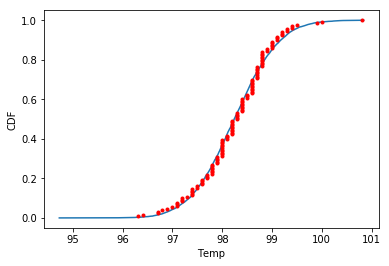

In [138]:
#write a function that takes as input a 1D array of data and then returns the x and y values of the ECDF.

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# Get the CDF of the samples and of the data
x_theor,y_theor = ecdf(samples)
x,y = ecdf(df_temp)

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.',color='red', linestyle='none')
_ = plt.xlabel('Temp')
_ = plt.ylabel('CDF')
plt.show()


### Chi-Square Test

Using the Chi-square test we can verify the visual test results. 

$$X^2=\sum_{i=1}^n \frac{(O_i - E_i)^2}{E_i}$$

The observed mean values of the data sample points ($O_i$) will be compared to our expected mean value ($E_i$). We can conclude that the data has a normal distribution confirming $E_i = u_x$ by calculating the p-value from the chi-square statistic with a significance level of ($\alpha = 0.05$ ). If the $\alpha < 0.05$ the null hypothesis is rejected.

$H_{o}$ : Sample distribution is normal. ($E_i = u_x$) 

$H_{a}$ : Sample distribution is not normal.

Since the p-value = 1 is greater than $\alpha$, the test fails to reject null hypothesis. Therefore we can conclude that it is a normal distribution.

In [139]:
#Chi-square formula: chi_sq
chi_sq = np.sum(((df_temp - df_mean) ** 2) / df_mean)

#Degrees of freedom is the length of dataframe minus 1 : deg_freedom
deg_freedom = len(df_temp) - 1

#Calculate p-value and then print it
p_value = 1 - stats.chi2.cdf(chi_sq, deg_freedom)
print ('p_value = ' + str (p_value))

p_value = 1.0


## 2. Is the sample size large? Are the observations independent?

Although the data does not mention if the recorded data was taken with replacement, since the sample size, n < 10% of the world population, we can assume that the data is independent.

In [140]:
#Check to see data size
df_len = len(df_temp)
df_len

130

## 3. Is the true population mean really 98.6 degrees F?

$H_{o}$ : Sample distribution mean is the same as true population mean of 98.6 degrees F.

$H_{a}$ : Sample distribution is not the same as true population mean of 98.6 degrees F.

## bootstrap hypothesis test

In [141]:
# Define a function that resamples the data and computes the summary statistic 
#computed from each sample

def bootstrap_replicate_1d(data, func):
    a = np.random.choice(data, size=len(data))
    return func(a)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.zeros(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)   

    return bs_replicates


/Users/rachelraikar/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


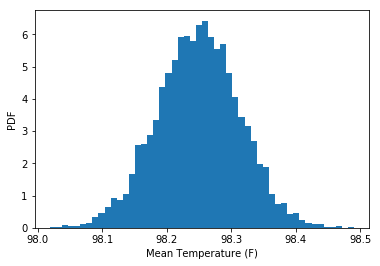

In [142]:
#resample the data 10000 times and make a sampling distribution of the sample mean

temp_rep = draw_bs_reps(df_temp,np.mean,size=10000)

#plot histogram of the results

_ = plt.hist(temp_rep, bins=50, normed=True)
_ = plt.xlabel('Mean Temperature (F)')
_ = plt.ylabel('PDF')

#Find a confidence interval of 95%
conf_interval = np.percentile(temp_rep, [2.5,97.5])


In [143]:
#Find the mean of the sampling distribution of the sample mean
print('df mean = ' + str(np.mean(df_temp)))
print('df std = ' + str(np.std(df_temp)))

print('sampling distribution mean = ' + str(np.mean(temp_rep)))
print('sampling distribution std = ' +str(np.std(temp_rep)))

print('confidence interval = ' + str(conf_interval))

df mean = 98.24923076923078
df std = 0.7303577789050377
sampling distribution mean = 98.24889876923078
sampling distribution std = 0.06375238861491005
confidence interval = [98.12       98.37232692]


### 3. A one-sample test would be used in this case since we are comparing one set of data to a single statistic.                       

###It would be appropriate to use a t-test since the standard deviation of the population is not known. Instead it can be approximated by finding the standard deviation of the sample. 

## Frequentist statistical testing

A one-sample test would be used in this case since we are comparing one set of data to a single statistic. Compared to a two-sample test which compares two sets of data. 

Although we will be calculating both the z-statistic and t-statistic, the t-statistic would be more appropriate to use the t-statistic. Since we are not provided with the standard deviation ($\sigma_\overline{x}$) of the sample distribution, the statistics are estimated with the standard error of the sampling distribution of the sample mean ($S_\overline{x}$).

But since the sample is large, the sampling distribution can be estimated as normal, so ($S_\overline{x}(n>30)$), the z-test would work as well. 

In [144]:
#Perform the z-test to calculate p-value

#Calculate z-statistic : z
z = (df_mean - 98.6)/ (df_std/np.sqrt(130))

#Calculate p-value from z-statistic : pval_ztest
pval_ztest = stats.norm.cdf(z)*2

#print both values
print('z-statistic: ' + str (z))
print('p-value: ' + str(pval_ztest))

z-statistic: -5.475925202078116
p-value: 4.3523151658821886e-08


In [145]:
#Perform the t-test to calculate p-value

#Calculate t-statistic : t
t = (df_mean - 98.6) / (df_std/np.sqrt(130))

#Calculate p-value from t-statistic : pval_ttest
pval_ttest = stats.t.sf(np.abs(t), 130 - 1)*2

#print both values
print('t-statistic: ' + str (t))
print('p-value: ' + str(pval_ttest))

t-statistic: -5.475925202078116
p-value: 2.1887464624095175e-07


## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

Since the sample size is small (n< 30), the distribution may match the parent population. We cannot estimate it as normal in this case. When the distribution is not normal, the t-statistic is better because it normalizes it to calculate the p-value. 

In [146]:
#take a random sample of n=10
df_10 = np.random.choice(df_temp, size=10)

#calculate standard deviation of the sample
df_10_std = np.std(df_10)
df_10

array([98.4, 99. , 98.7, 98.8, 97.8, 97.9, 98.5, 98.6, 97.2, 98.4])

In [147]:
#Perform the z-test for df_10 to calculate p-value

#Calculate z-statistic : z_10
z_10 = (np.mean(df_10) - 98.6)/ (df_std/np.sqrt(10))

#Calculate p-value from z-statistic : pval_ztest10
pval_ztest10 = stats.norm.cdf(z_10)*2

#print both values
print('z-statistic (n=10): ' + str (z_10))
print('p-value (n=10): ' + str(pval_ztest10))

z-statistic (n=10): -1.1690365912518943
p-value (n=10): 0.24238888914518997


In [148]:
#Perform the t-test on df_10 to calculate p-value

#Calculate t-statistic : t_10
t_10 = (np.mean(df_10) - 98.6) / (df_10_std/np.sqrt(10))

#Calculate p-value from t-statistic : pval_ttest10
pval_ttest10 = stats.t.sf(np.abs(t_10), 10 - 1)*2

#print both values
print('t-statistic (n=10): ' + str (t_10))
print('p-value (n=10): ' + str(pval_ttest10))

t-statistic (n=10): -1.6551651245805927
p-value (n=10): 0.13227556853203684


## 5. At what temperature should we consider someone's temperature to be "abnormal"?

To calculate when someone's temperature is 'abnormal' we will assume a confidence interval of 95%. So anything outside two standard deviations from the mean of the sample population ($2\sigma_\overline{x}$) will be considered 'abnormal'. To find the 'abnormal body temperatures, we will use the bootstrap and frequentist methods to calculate $2\sigma_\overline{x}$ which will give us the margins of error.

I will be using the t-statistic since we do not know the population variance so it will be estimated using the standard error ($S_\overline{x}$).

In [149]:
crit_t_stat = stats.t.isf([0.975, 0.025], [df_len - 1])
margin_of_error = crit_t_stat * (df_std / np.sqrt(df_len))
confidence_interval = df_mean + margin_of_error

print('Confidence interval from bootstrap method = ' +str(conf_interval))
print ('Confidence interval from frequentist method = ' +str(confidence_interval))

Confidence interval from bootstrap method = [98.12       98.37232692]
Confidence interval from frequentist method = [98.12249319 98.37596835]


The abnormal temperatures are anything outside this confidence interval.

## 6. Is there a significant difference between males and females in normal temperature?

To check if there is a difference between male and female temperatures, we will be performing a two-sample z-test. 

The mean of the male temperatures ($\mu_X$) and the mean of the female temperatures ($\mu_Y$) will be calculated to obtain confidence interval of $\mu_{X-Y}$. If 0 is in that interval, we fail to reject the null hypthesis.

$H_{o}$ : No significant difference between males and female mean body temperature ($\mu_{X-Y} = 0$) 

$H_{a}$ : Significant difference between males and female mean body temperature ($\mu_{X-Y} \neq 0$) 

In [150]:
#Create an array of the male and female temperatures
male = df.temperature[df.gender == 'M']
female = df.temperature[df.gender == 'F']

#Find mean temperatures for males and females
male_mean_temp = np.mean(male)
female_mean_temp = np.mean(female)

#Find standard deviation from mean temperature of males and females
male_std = np.sqrt(np.var(male) / len(male))
female_std = np.sqrt(np.var(female) / len(female))

#Find difference between the mean and stds between the genders
mean_difference = male_mean_temp -female_mean_temp
std_difference = male_std - female_std

#calculate confidence interval
gender_confidence_interval = mean_difference + np.array([-1, +1]) * 1.96 * std_difference
print(gender_confidence_interval)

[-0.27844004 -0.3000215 ]


Since 0 is not in the confidence interval, we reject the null hypothesis and can confidently say that there is a significant difference between male and female body temperatures. 